[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mister-AI-S/Book-01-Machine-Learning-Supervised-Learning/blob/main/Code06_Support_Vector_Regression_Ex01.ipynb)


In [258]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Dataset Preparation

#### We create a simple dataset of input-output pairs (x,y) and normalize the data for better numerical stability.

### Explanation:
#### Normalization ensures that all input features have similar scales, improving optimization.

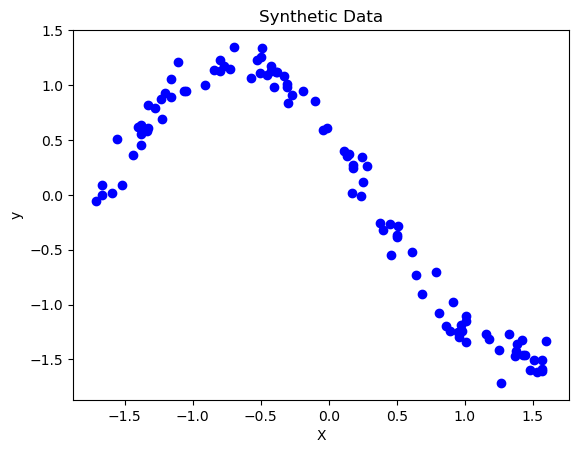

In [261]:
# Input (features) and output (target) data

X = np.sort(5 * np.random.rand(100, 1), axis=0)  # Features
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])  # Target with noise

# Normalize the data (optional but recommended for better performance)
X = (X - np.mean(X)) / np.std(X)
y = (y - np.mean(y)) / np.std(y)

# Plotting the data
plt.scatter(X, y, color='blue')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Data")
plt.show()

## Step 2: Kernel Computation
#### We define a kernel function to compute similarity between data points. For this example, we use the Radial Basis Function (RBF) kernel.

### Explanation:
#### The kernel allows us to handle non-linear relationships by implicitly mapping data to higher-dimensional spaces.

In [264]:
def rbf_kernel(x1, x2, gamma=0.5):
    """
    Radial Basis Function (RBF) kernel.
    Args:
        x1: First data point.
        x2: Second data point.
        gamma: Kernel hyperparameter.
    Returns:
        Kernel similarity value.
    """
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Compute the kernel matrix
def compute_kernel_matrix(X, kernel_func, gamma=0.5):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_func(X[i], X[j], gamma)
    return K

# Compute the kernel matrix for the dataset
K = compute_kernel_matrix(X, rbf_kernel, gamma=0.5)



## Step 3: Dual Problem Formulation and Optimization
#### We reformulate SVR's optimization problem as a dual problem. The dual problem finds Lagrange multipliers (α,α∗) that optimize the regression function.

#### We solve the dual problem iteratively using a simple gradient descent approach.

### Explanation:
#### The dual formulation involves maximizing an objective function subject to constraints.
#### It uses the kernel matrix 𝐾 to handle non-linear transformations implicitly.
#### The gradients are computed for each Lagrange multiplier, and the values are updated iteratively. Constraints like 0≤𝛼_𝑖≤𝐶 are enforced using clipping.

In [267]:
 def train_svr(X, y, epsilon=0.2, C=1, gamma=0.5, max_iter=1000, lr=0.01):
    """
    Train an SVR model using the dual formulation.
    Args:
        X: Input data (n_samples, n_features).
        y: Target values (n_samples,).
        epsilon: Epsilon-insensitive margin.
        C: Regularization parameter.
        gamma: Kernel parameter (for RBF kernel).
        max_iter: Maximum iterations for optimization.
        lr: Learning rate for gradient descent.
    Returns:
        Alpha values and the kernel matrix.
    """
    n_samples = X.shape[0]
    K = compute_kernel_matrix(X, rbf_kernel, gamma)

    # Initialize Lagrange multipliers (alpha and alpha*)
    alpha = np.zeros(n_samples)
    alpha_star = np.zeros(n_samples)

    # Gradient descent to optimize alpha and alpha_star
    for _ in range(max_iter):
        for i in range(n_samples):
            # Compute the gradients
            grad_alpha = np.sum((alpha - alpha_star) * K[:, i]) - y[i] + epsilon
            grad_alpha_star = -np.sum((alpha - alpha_star) * K[:, i]) + y[i] + epsilon

            # Update alpha and alpha_star
            alpha[i] = np.clip(alpha[i] - lr * grad_alpha, 0, C)
            alpha_star[i] = np.clip(alpha_star[i] - lr * grad_alpha_star, 0, C)

    return alpha, alpha_star, K


## Step 4: Compute the Bias Term
#### After optimizing 𝛼 and 𝛼∗, we compute the bias term 𝑏.

### Explanation:
#### The bias ensures the regression function is properly shifted to minimize error.

In [302]:
# Compute the bias term
def compute_bias(X, y, alpha, alpha_star, K, epsilon, C):
    n_samples = X.shape[0]
    b = []
    count = 0
    for i in range(n_samples):
        if 0 < alpha[i] < C or 0 < alpha_star[i] < C:  # Support vectors


 # Compute the summation term
            summation = np.sum((alpha - alpha_star) * K[:, i])
            
            # Compute b for this support vector using KKT conditions
            b_pos = y[i] - epsilon - summation
            b_neg = y[i] + epsilon - summation
            
            # Append both values for stability
            b.append(b_pos)
            b.append(b_neg)

    # Average the bias values for numerical stability
    return np.mean(b) if len(b) > 0 else 0


# Hyperparameters
C = 1  # Regularization parameter
epsilon = 0.2  # Epsilon margin

b = compute_bias(X, y, alpha, alpha_star, K, epsilon, C)

-0.04986816251903094

## Step 5: Make Predictions
#### Finally, we use the optimized parameters (𝛼, 𝛼∗, b) to make predictions.

### Explanation:
#### The regression function is evaluated using the kernel and the support vectors.

In [297]:
# Predict new values
def predict(X_train, X_test, alpha, alpha_star, b, K, gamma=0.5):
    predictions = []
    for x in X_test:
        prediction = b + np.sum(
            (alpha - alpha_star) * np.array([rbf_kernel(x, x_train, gamma) for x_train in X_train])
        )
        predictions.append(prediction)
    return np.array(predictions)

# Train the SVR model
alpha, alpha_star, K = train_svr(X, y, epsilon=0.2, C=1, gamma=0.5, max_iter=1000, lr=0.01)

# Predict on training data
y_pred = predict(X, X, alpha, alpha_star, b, K, gamma=0.5) 

## Step 6: Visualize Results
#### Plot the predicted regression line against the actual data points.

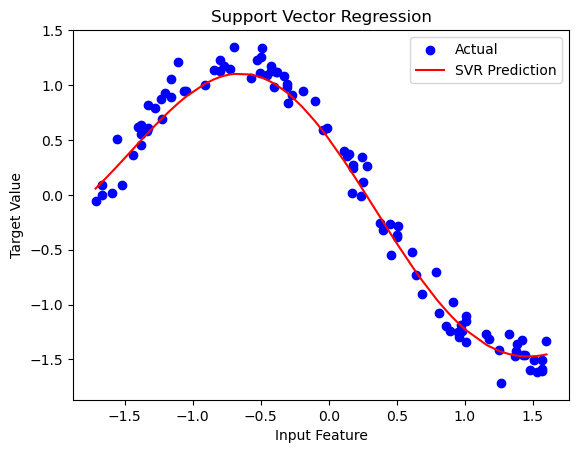

In [299]:
# Plot the results
plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='SVR Prediction')
plt.title('Support Vector Regression')
plt.xlabel('Input Feature')
plt.ylabel('Target Value')
plt.legend()
plt.show()